# Social Networks and Text Analysis - Null Models


In [1]:
from random import sample, randint, shuffle
import numpy as np
import networkx as nx
from scipy.stats import zscore
from scipy.stats import norm
from statsmodels.stats.weightstats import ztest
import matplotlib.pyplot as plt

# Q1
Create a function that will use a z-score test to compare a real graph against a random graph according to a list of metrics provided by the user. 

In [15]:
#Real data (simluated in this case but it should be you real data)

g_real = nx.watts_strogatz_graph(100,3,0.6) 
#metrics for the analysis is the closeness centrality of node number 20

real_metrics=nx.closeness_centrality(g_real)[20]



In [16]:
#creation of the sample size 

sample_size=1000

sample_metrics=[]

for k in range(sample_size):
    g2 =nx.watts_strogatz_graph(100,3,0.6) 
    sample_metrics.append(nx.closeness_centrality(g2)[20])



z-score: -0.7835262422700836


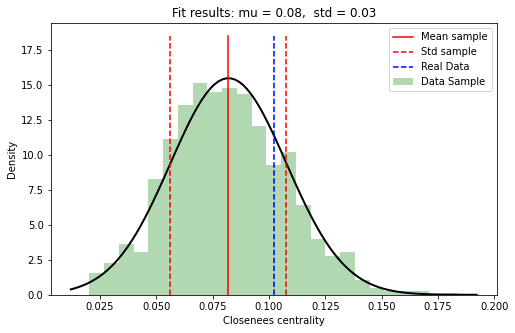

In [17]:
data=sample_metrics
# Fit a normal distribution to the data:
mu, std = norm.fit(data)

plt.figure(figsize=(8,5))

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.3, color='g',label='Data Sample')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

y_mean=np.arange(0,max(p)*1.2,0.1)
x_mean=np.zeros(len(y_mean))+mu
x_std_p=np.zeros(len(y_mean))+mu+std
x_std_m=np.zeros(len(y_mean))+mu-std


x_real_data=np.zeros(len(y_mean))+real_metrics

plt.plot(x_mean,y_mean,color='r',label='Mean sample')
plt.plot(x_std_m,y_mean,'--',color='r')
plt.plot(x_std_p,y_mean,'--',color='r',label='Std sample')

plt.plot(x_real_data,y_mean,'--',color='b',label='Real Data')
plt.legend()
plt.xlabel('Closenees centrality')
plt.ylabel('Density')
zscore=(mu-real_metrics)/std
print('z-score: '+str(zscore))

## Q1a

Load a real dataset of a network of your choice, and use the function you have defined to compare it to a small world network – what do you notice? How deeply can you compare the two networks, and what other pieces of information would you need to understand whether your networks are very similar or not?

# Q2. 

Implement the Curveball Algorithm as discussed in class.

* Select an undirected binary network from one of the repositories we discussed during the class (e.g. SNAP)
* Generate a random sample based on that network using the Curveball Algorithm 
* Select a graph level metric (e.g. degree distribution) and the random sample, and compare using a z-score test. 
* Select a node level metric (e.g. degree) for a random node in your real network, and use the z-score to compare to the distrubtion of that same metric for the random network. 
* Plot both of these. 
* What do you observe from these results?


In [18]:
# Load the network and the relevant packages
import pandas as pd
import igraph as ig
import networkx as nx
import numpy as np



In [612]:
def randbin(M,N,P):  
    return np.random.choice([0, 1], size=(M,N), p=[P, 1-P])

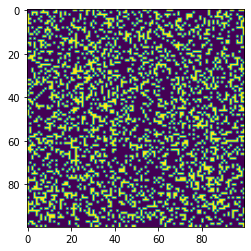

In [616]:
# this is our "real" directed matrix data 
matrix=randbin(100,100,.7)
plt.imshow(matrix)

In [622]:
g_real=nx.from_numpy_matrix(matrix,create_using=nx.DiGraph)
real_clust=nx.average_clustering(g_real)

In [617]:
# Generate a random smaple using the curveball algorithm
'''Supplementary Software 3 A possible implementation of the Curveball Algorithm in Python programming language'''
''' From https://www.nature.com/articles/ncomms5114#Sec9'''

from random import sample, randint, shuffle
import numpy as np


def find_presences(input_matrix):
	num_rows, num_cols = input_matrix.shape
	hp = []
	iters = num_rows if num_cols >= num_rows else num_cols
	input_matrix_b = input_matrix if num_cols >= num_rows else np.transpose(input_matrix)
	for r in range(iters):
		hp.append(list(np.where(input_matrix_b[r] == 1)[0]))
	return hp


def curve_ball(input_matrix, r_hp, num_iterations=-1):
	num_rows, num_cols = input_matrix.shape
	l = list(range(len(r_hp)))
	num_iters = 5*min(num_rows, num_cols) if num_iterations == -1 else num_iterations
	for rep in range(num_iters):
		AB = sample(l, 2)
		a = AB[0]
		b = AB[1]
		ab = set(r_hp[a])&set(r_hp[b]) # common elements
		l_ab=len(ab)
		l_a=len(r_hp[a])
		l_b=len(r_hp[b])
		if l_ab not in [l_a,l_b]:		
			tot=list(set(r_hp[a]+r_hp[b])-ab)
			ab=list(ab)	
			shuffle(tot)
			L=l_a-l_ab
			r_hp[a] = ab+tot[:L]
			r_hp[b] = ab+tot[L:]
	out_mat = np.zeros(input_matrix.shape, dtype='int8') if num_cols >= num_rows else np.zeros(input_matrix.T.shape, dtype='int8')
	for r in range(min(num_rows, num_cols)):
		out_mat[r, r_hp[r]] = 1
	result = out_mat if num_cols >= num_rows else out_mat.T
	return result

In [624]:
presence = find_presences(matrix)

# Create the ensemble of re-wired graphs
random_graphs = []

for i in range(1000):
    random_graphs.append(nx.from_numpy_array(curve_ball(matrix, presence,50),create_using=nx.DiGraph))

In [625]:
# Calculate the avg clustering coefficient for the real graph and an ensemble of random graphs
random_graph_clustering_coefs = []
counter = 0
for graph in random_graphs:
    #print(counter)
    random_graph_clustering_coefs.append(nx.average_clustering(graph))
    #counter += 1

z-score: -0.1454635595534362


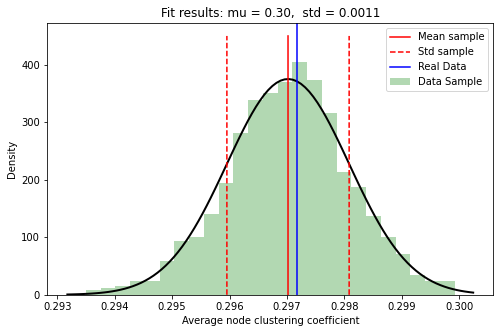

In [627]:
# Compare the two distributions

data = random_graph_clustering_coefs
# Fit a normal distribution to the data:
mu, std = norm.fit(data)

plt.figure(figsize=(8,5))

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.3, color='g',label='Data Sample')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.4f" % (mu, std)
plt.title(title)

y_mean=np.arange(0,max(p)*1.2,0.1)
x_mean=np.zeros(len(y_mean))+mu
x_std_p=np.zeros(len(y_mean))+mu+std
x_std_m=np.zeros(len(y_mean))+mu-std


x_real_data=np.zeros(len(y_mean))+real_metrics

plt.plot(x_mean,y_mean,color='r',label='Mean sample')
plt.plot(x_std_m,y_mean,'--',color='r')
plt.plot(x_std_p,y_mean,'--',color='r',label='Std sample')

#plt.axvline(facebook_clustering,color='b',label='Real Data')
plt.axvline(real_clust,color='b',label='Real Data')
plt.legend()
plt.xlabel('Average node clustering coefficient')
plt.ylabel('Density')
zscore=(mu-real_clust)/std
print('z-score: '+str(zscore))